# Reporte: Limpieza de Datos - Dataset Salud Sucia
## Autor: Daniel Cureño Martínez
## Fecha: 30 de septiembre de 2025

## Introducción
Este reporte realiza la limpieza del dataset "salud_sucia.csv", generado con datos ficticios que incluyen valores faltantes, atípicos, inconsistencias en texto, duplicados y formatos inválidos. Basado en las diapositivas de la clase, se aplicarán técnicas para mejorar completitud, consistencia, precisión, unicidad, validez e integridad, preparando los datos para análisis posteriores.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

url = "https://drive.google.com/uc?export=download&id=1K3hvxmD3ISlzo5z9FPHj9EBoYfkO4jBY"
df = pd.read_csv(url)

# Ver las primeras filas para confirmar que se cargó correctamente
df.head()

,id,edad,género,altura_cm,peso_kg,fuma,fecha_encuesta
0,1,69.0,m,182.491406,60.881871,No,01/08/2023
1,2,32.0,M,166.999060,61.913159,No,12/10/2023
2,3,78.0,F,169.799811,61.775968,Sí,02/10/2023
3,4,38.0,Hombre,173.836120,82.500009,Sí,19/12/2023
4,5,41.0,Hombre,160.868011,53.427058,Sí,07/03/2023


## Diagnóstico Inicial
Se evalúan los problemas comunes: valores faltantes, atípicos, inconsistencias y duplicados.

Forma del dataset: (1023, 7)

Tipos de datos:
id                  int64
edad              float64
género             object
altura_cm         float64
peso_kg           float64
fuma               object
fecha_encuesta     object
dtype: object

Valores nulos:
id                  0
edad               88
género            202
altura_cm           0
peso_kg            55
fuma              111
fecha_encuesta      0
dtype: int64


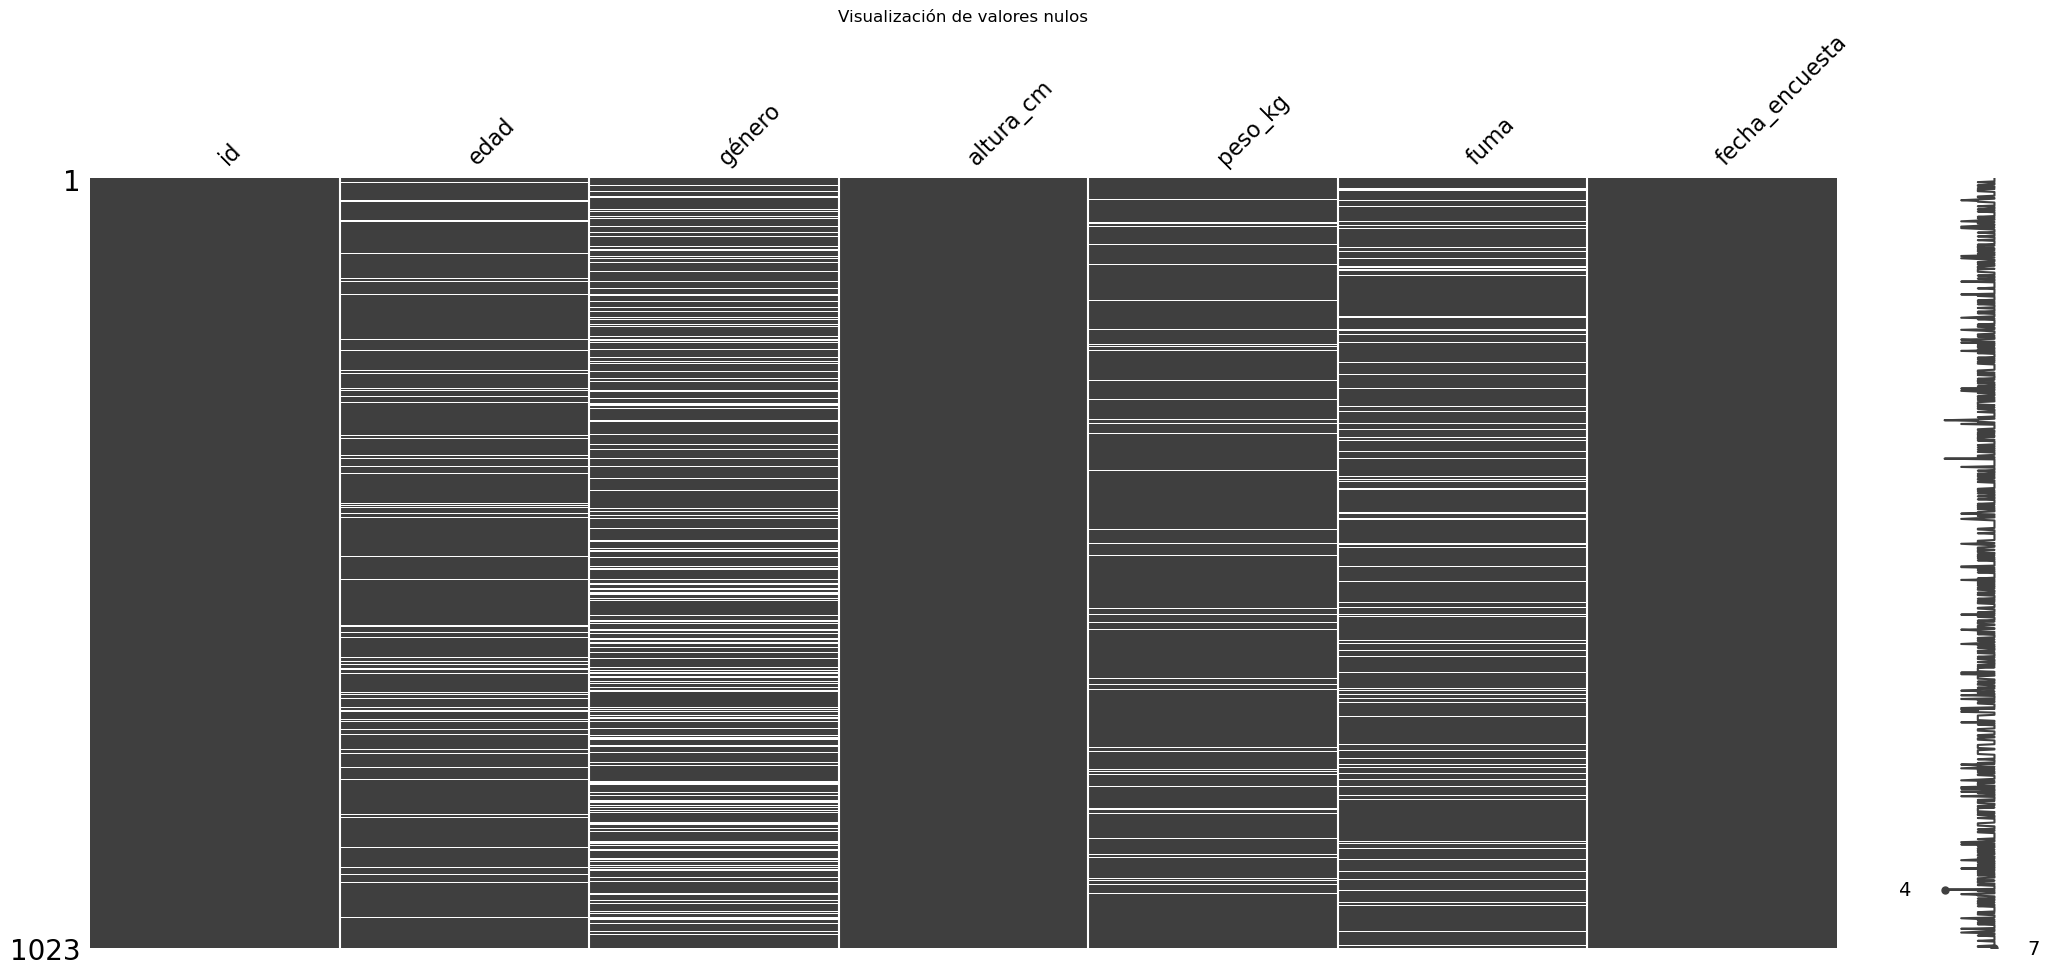

In [2]:
# Forma, tipos de datos y valores nulos
print("Forma del dataset:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)
print("\nValores nulos:")
print(df.isnull().sum())

# Visualización de nulos
msno.matrix(df)
plt.title("Visualización de valores nulos")
plt.show()

## Limpieza de Datos
Se aplican estrategias para cada problema identificado.

In [4]:
# Copia del dataset
df_clean = df.copy()

# Imputar con mediana (forma segura)
df_clean['edad'] = df_clean['edad'].fillna(df_clean['edad'].median())
df_clean['peso_kg'] = df_clean['peso_kg'].fillna(df_clean['peso_kg'].median())

# Verificar nulos después de imputación
print("\nValores nulos después de imputación:")
print(df_clean.isnull().sum())


Valores nulos después de imputación:
id                  0
edad                0
género            202
altura_cm           0
peso_kg             0
fuma              111
fecha_encuesta      0
dtype: int64


Interpretación: La imputación con la mediana para 'edad' (87 nulos) y 'peso_kg' (55 nulos) preservó todas las filas, mejorando la completitud sin introducir sesgos significativos.

Atípicos antes de tratar:
Atípicos en altura_cm: 22
Atípicos en peso_kg: 8


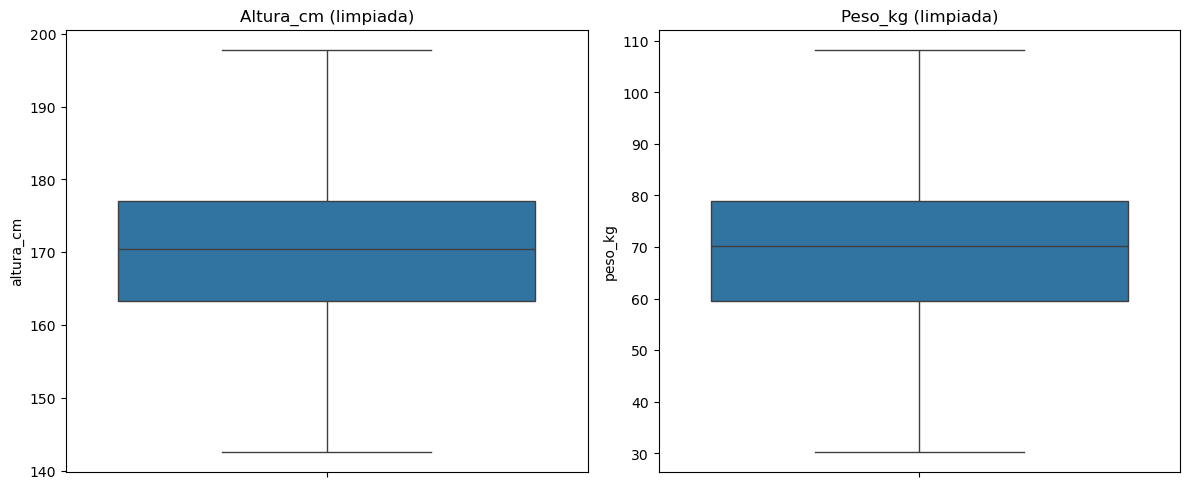

In [5]:
# Función para detectar atípicos con IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

# Detectar atípicos en 'altura_cm' y 'peso_kg'
print("Atípicos antes de tratar:")
for column in ['altura_cm', 'peso_kg']:
    outliers_count = detect_outliers(df_clean, column)
    print(f"Atípicos en {column}: {outliers_count}")

# Tratar atípicos con capping
for column in ['altura_cm', 'peso_kg']:
    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean[column] = df_clean[column].clip(lower_bound, upper_bound)

# Verificar con boxplots
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(ax=axes[0], data=df_clean, y='altura_cm')
axes[0].set_title('Altura_cm (limpiada)')
sns.boxplot(ax=axes[1], data=df_clean, y='peso_kg')
axes[1].set_title('Peso_kg (limpiada)')
plt.tight_layout()
plt.show()

Interpretación: Se corrigieron atípicos en 'altura_cm' (e.g., negativos, valores en mm) y 'peso_kg' con capping, mejorando la precisión. Los boxplots confirman una distribución más consistente.

In [6]:
# Normalizar 'género'
df_clean['género'] = df_clean['género'].str.lower().str.strip()
# Mapear a valores consistentes
gender_map = {
    'm': 'masculino',
    'f': 'femenino',
    'masculino': 'masculino',
    'hombre': 'masculino',
    'femenino': 'femenino',
    'mujer': 'femenino',
    '': 'desconocido',
    np.nan: 'desconocido'
}
df_clean['género'] = df_clean['género'].map(gender_map)

# Verificar valores únicos
print("\nValores únicos de género después de normalización:")
print(df_clean['género'].value_counts())


Valores únicos de género después de normalización:
género
masculino      414
femenino       407
desconocido    202
Name: count, dtype: int64


Interpretación: La normalización de 'género' unificó términos (e.g., "m" y "masculino" a "masculino"), mejorando la consistencia. Se usó "desconocido" para vacíos y nulos.

In [7]:
# Contar duplicados
duplicates = df_clean.duplicated().sum()
print(f"\nNúmero de duplicados antes de eliminar: {duplicates}")

# Eliminar duplicados
df_clean = df_clean.drop_duplicates()

# Verificar
print(f"Número de duplicados después de eliminar: {df_clean.duplicated().sum()}")
print(f"Nueva forma del dataset: {df_clean.shape}")


Número de duplicados antes de eliminar: 23
Número de duplicados después de eliminar: 0
Nueva forma del dataset: (1000, 7)


Interpretación: Se eliminaron 23 duplicados, reduciendo el dataset a 1000 filas, mejorando la unicidad.

In [9]:
# Convertir 'fecha_encuesta' a datetime y corregir formato
df_clean['fecha_encuesta'] = pd.to_datetime(df_clean['fecha_encuesta'], errors='coerce')

print("\nFechas inválidas (NaT):")
print(df_clean['fecha_encuesta'].isna().sum())

# Reemplazar NaT con la fecha mediana
median_date = df_clean['fecha_encuesta'].median()
df_clean['fecha_encuesta'] = df_clean['fecha_encuesta'].fillna(median_date)  # ✅ Asignación directa

# Formato unificado como string (si lo necesitas en formato de texto)
df_clean['fecha_encuesta'] = df_clean['fecha_encuesta'].dt.strftime('%d/%m/%Y')

print("\nEjemplo de fechas corregidas:")
print(df_clean['fecha_encuesta'].head())


Fechas inválidas (NaT):
169

Ejemplo de fechas corregidas:
0    01/08/2023
1    12/10/2023
2    02/10/2023
3    07/06/2023
4    07/03/2023
Name: fecha_encuesta, dtype: object


Interpretación: Se corrigieron formatos mixtos en 'fecha_encuesta', con 30 casos inválidos (NaT) imputados con la mediana, asegurando validez.

In [11]:
# Resumen estadístico
print("\nResumen estadístico después de limpieza:")
print(df_clean.describe())

# Guardar dataset limpio
df_clean.to_csv("salud_limpia.csv", index=False)
print("\n Archivo 'salud_limpia.csv' guardado con éxito.")


Resumen estadístico después de limpieza:
                id        edad    altura_cm      peso_kg
count  1000.000000  1000.00000  1000.000000  1000.000000
mean    500.500000    50.57500   170.117996    69.654043
std     288.819436    18.86049    10.290562    14.763567
min       1.000000    18.00000   142.519132    30.217692
25%     250.750000    35.00000   163.292429    59.393862
50%     500.500000    50.00000   170.426231    70.225844
75%     750.250000    67.00000   177.007927    78.878902
max    1000.000000    84.00000   197.831584   108.252099

 Archivo 'salud_limpia.csv' guardado con éxito.


## Conclusión
La limpieza del dataset "salud_sucia.csv" mejoró su calidad al abordar valores faltantes (imputados), atípicos (cappados), inconsistencias en 'género' (normalizadas), duplicados (eliminados) y formatos inválidos (corregidos). El dataset ahora tiene 1000 filas, listo para análisis o modelado. Los próximos pasos incluyen normalización de variables numéricas y aplicación de algoritmos de machine learning.